<a href="https://colab.research.google.com/github/HongJeongHwan/BigData/blob/main/mouse_classify_withclass_ver1_20240711.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##■ 마우스 완제품/반제품 이미지 분류

###→ 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###→ 필요한 라이브러리 추가

In [ ]:
### 필요한 라이브러리/함수 import
import tensorflow as tf
import numpy as np
from PIL import Image
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
import random
import os
from datetime import datetime

# target image size 설정
HEIGHT = 224
WIDTH = 224

###→ 메타데이터 관련 함수 정의

In [ ]:
# 이미지의 meta 정보를 확인
def get_image_exif(image):
    img = Image.open(image)
    # print(f'img = {img}')
    img_info = img._getexif()
    # print(f'img_info = {img_info}') #
    for tag_id in img_info:
        tag = TAGS.get(tag_id, tag_id)
        data = img_info.get(tag_id)
        # print(f'{tag} : {data}')
        if tag == 'Artist':
            print(f'분류결과 : {data}')
        elif tag == 'XResolution':
            print(f'분류확률 : {data}')
    img.close()

# 이미지의 meta 정보를 수정
def change_exif_date(image_path, classified_result, classified_percent):

    myTags = {}  ### TAGS.get() 이 자꾸 에러라서 만들어서 사용
    try:
        image = Image.open(image_path)
        exif = image._getexif()
        exif_data = {}

        # Extract EXIF data
        if exif:
            for tag, value in exif.items():
                decoded = TAGS.get(tag, tag)
                #print(tag)
                if decoded != 'ExifOffset':  #에러부분 제외
                    exif_data[decoded] = value
                    myTags[decoded] = tag  ## tag 에 해당하는 tag_id 설정

            # Update DateTimeOriginal and DateTime tags
            exif_data['Artist'] = classified_result
            exif_data['XResolution'] = classified_percent

            # print(f'type(myTags) =\n{myTags}')

            # Encode EXIF data
            exif_bytes = Image.Exif()
            #print(exif_bytes)
            #print(exif_data)
            for tag, value in exif_data.items():
                #tag_id = TAGS.get(tag)  리턴이 None임. 왕 짜증
                tag_id = myTags.get(tag)  ##만든 dictionary에서 받아 사용
                exif_bytes[tag_id] = value
                #print(tag_id)

            # print(f'exif_bytes =\n{exif_bytes}')
            # Insert modified EXIF data back into the image
            image.save(image_path, exif=exif_bytes)
            print("모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.")
        else:
            print("No EXIF data found in the image.")
    except Exception as e:
        print(f"An error occurred: {e}")

###→ 데이터생성 class 정의

In [ ]:
class DataGenerator:
    # __train_dir__   = '/content/drive/MyDrive/KDT/05_딥러닝/02_컴퓨터비전/02_Data파일/mouse/train'
    # __val_dir__     = '/content/drive/MyDrive/KDT/05_딥러닝/02_컴퓨터비전/02_Data파일/mouse/val'
    __train_dir__   = '/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/train'
    __val_dir__     = '/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/val'
    __test_dir__    = '/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test'

    def __init__(self): # 클래스 생성자
        pass
    # 데이터 증식 및 조건 설정
    def make_datagen(self, augmentation):
        self.augmentation = augmentation
        if self.augmentation:
            return tf.keras.preprocessing.image.ImageDataGenerator(
                        # scaling
                        rescale=1./255,

                        # 하이퍼 파라미터 설정
                        rotation_range=30,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='nearest')
        else:
            return tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    # 입력이미지 설정
    def make_datagen_flow_from_dir(self, datagen, gubun):
        self.datagen = datagen
        self.gubun = gubun

        if self.gubun == 'train':
            dir = self.__train_dir__
        elif self.gubun == 'val':
            dir = self.__val_dir__
        elif self.gubun == 'test':
            dir = self.__test_dir__

        data_generator = self.datagen.flow_from_directory(
            directory = dir,
            target_size = (HEIGHT, WIDTH),
            class_mode = 'categorical',
            batch_size = 20,
            seed=0)
        return data_generator

###→ 모델생성 class 정의

In [ ]:
class Model:

    # 생성 모델 멤버변수
    pretrained_model = finetuned_model = ''

    ### 학습 결과를 저장할 디렉토리 생성
    # __model_dir__ = './data/model'
    # __model_dir__   = '/content/drive/MyDrive/KDT/05_딥러닝/02_컴퓨터비전/02_Data파일/mouse/model'
    # __test_dir__    = '/content/drive/MyDrive/KDT/05_딥러닝/02_컴퓨터비전/02_Data파일/mouse/test'
    __model_dir__   = '/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/model'
    __test_dir__    = '/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test'

    # 출력 units 설정
    __units__ = 2

    def __init__(self, model): # 클래스 생성자
        self.model = model

        ### 랜덤 시드 설정
        random.seed(0)
        np.random.seed(0)
        tf.random.set_seed(0)
        self.glorot_uniform=tf.keras.initializers.GlorotUniform(seed=0)

    # pretrained_model create
    def make_pretrained_model(self):
        if self.model == 'vgg16':
            self.pretrained_model = tf.keras.applications.vgg16.VGG16(
                include_top = False,
                weights = 'imagenet',
                input_shape = (HEIGHT, WIDTH, 3))
        elif self.model == 'resnet':
            self.pretrained_model = tf.keras.applications.resnet_v2.ResNet152V2(
                include_top = False,
                weights = 'imagenet',
                input_shape = (HEIGHT, WIDTH, 3))

        # freezing
        for layer in self.pretrained_model.layers:
            layer.trainable = False

        # model_summary
        self.pretrained_model.summary()

    # fine-tuning_model create
    def make_finetuned_model(self):
        # 모델구성
        self.finetuned_model = tf.keras.Sequential()
        self.finetuned_model.add(self.pretrained_model)
        self.finetuned_model.add(tf.keras.layers.Flatten())
        self.finetuned_model.add(tf.keras.layers.Dense(units=256,
                                                       activation='relu',
                                                       kernel_initializer=self.glorot_uniform))
        self.finetuned_model.add(tf.keras.layers.Dropout(rate=0.5))
        self.finetuned_model.add(tf.keras.layers.Dense(units=2,
                                                       activation='softmax',
                                                       kernel_initializer=self.glorot_uniform))
        # model_summary
        self.finetuned_model.summary()

    def training(self, save_filename, train_generated, val_generated):
        self.save_filename = save_filename
        self.train_generated = train_generated
        self.val_generated = val_generated

        self.early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                           verbose = 1,
                                                           patience = 5)
        # 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
        self.checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath = self.__model_dir__ + '/' + self.save_filename,
            monitor = 'val_loss',
            verbose = 1,
            save_best_only = True)

        # 모델 컴파일
        self.finetuned_model.compile(loss='categorical_crossentropy',
                                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                     metrics=['accuracy'])

        # 학습
        history = self.finetuned_model.fit(self.train_generated,
                                           validation_data=self.val_generated,
                                           epochs=1000,
                                           callbacks = [self.early_stop, self.checkpoint])
        return history

    ## 학습 결과 시각화
    def plot(self, history):
        self.history = history

        fig, ax = plt.subplots(1, 2, figsize=(18,8))

        # accuracy, loss 추출 -> 그래프 y축 설정
        train_acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        train_loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        # 그래프 x축
        epochs = np.arange(1, len(train_acc)+1)

        # accuracy 시각화
        ax[0].plot(epochs, train_acc, c='b', label='Training acc')
        ax[0].plot(epochs, val_acc, c='g', label='Validation acc')
        ax[0].set_title('[Accuracy]', size=20)
        ax[0].set_xlabel('epochs') # X축
        ax[0].set_ylabel('accuracy', size=16) # y축
        ax[0].legend() # 범례 생성

        # loss 시각화
        ax[1].plot(epochs, train_loss, c='r', label='Training loss')
        ax[1].plot(epochs, val_loss, c='m', label='Validation loss')
        ax[1].set_title('[Loss]', size=20)
        ax[1].set_xlabel('epochs') # X축
        ax[1].set_ylabel('loss', size=16) # y축
        ax[1].legend() # 범례 생성

        plt.show()

    # 테스트 이미지 분류
    def classify_img(self):
        image_path = []

        for name in sorted(os.listdir(self.__test_dir__)):
            if name.find('.') > 0:
                image_path.append(self.__test_dir__ + '/' + name)
                print(self.__test_dir__ + '/' + name)
        # print(f'평가용 이미지 경로 확인 :\n{image_path}')

        # 평가용 이미지를 이용한 평가 진행
        for image in image_path:
            img = Image.open(image)
            img_array = np.array(img.resize((HEIGHT,WIDTH)))

            # 이미지 픽셀에 대한 rescaling
            X = img_array/255
            # 이미지는 3차원 --> 4차원으로 변환 : batch_size=1 --> (1,224,224,3)
            X = X.reshape(1,HEIGHT,WIDTH,3)

            # 정답 label 설정
            label = ['mouse_part','mouse_product']

            # 평가용 데이터를 이용한 예측 : 2차원 배열로 나온다.
            pred = self.finetuned_model.predict(X)
            # 예측값(확률)중 가장 높은 인덱스 추출
            idx = np.argmax(pred[0])    # pred가 2차원 배열이기 때문에 인덱싱을 통해 꺼내준다.
            # 정답 --> 숫자 대신 폴더명('mouse_part','product')으로 출력
            y = label[idx]
            print(f'모델의 예측 label : {y}')
            # 예측확률 추출
            print(f'정확도 : {np.max(pred)}')

            # 이미지 출력
            plt.imshow(img_array)
            plt.axis('off')
            plt.show()

    # 테스트 이미지 분류
    def classify_Karlo_img(self):
        image_path = []

        for fld in sorted(os.listdir(self.__test_dir__)):
            for name in sorted(os.listdir(self.__test_dir__ +'/'+str(fld))):
                if name.find('.') > 0:
                    image_path.append(self.__test_dir__ + '/' + str(fld) + '/' + name)
                    print(self.__test_dir__ +'/'+str(fld) + '/' + name)
                    # print(f'평가용 이미지 경로 확인 :\n{image_path}')

        # 평가용 이미지를 이용한 평가 진행
        for image in image_path:
            img=Image.open(image) # Image > 대문자
            # 이미지를 RGB로 변환
            img = img.convert('RGB')
            # resize 실행
            img=img.resize((HEIGHT,WIDTH))
            # 넘파이 배열로 변환
            img_array=np.array(img)
            img_array = np.expand_dims(img_array, axis=0) # <- X=X.reshape((1,224,224,3)) 에러라서 대체
            # 이미지 픽셀에 대한 rescaling
            X=img_array/255
            # batch_size=1 적용 > 이미지의 모양 > (1,224,224,3)
            # X=X.reshape((1,224,224,3))
            # 정답 label 설정
            label=["mouse_parts","mouse_product"]
            # 평가용 데이터를 이용한 예측
            pred = self.finetuned_model.predict(X)
            # 예측값(확률) 중 가장 높은 인덱스 추출 # pred 출력시 2차원 배열로 나온다
            idx=np.argmax(pred[0])
            # 정답 > 숫자 대신 폴더 이름으로 출력
            print(f"모델의 예측결과 label={label[idx]}")
            # 예측 확률 추출
            print(f"정확도:{np.max(pred)}")

            # meta 정보 출력
            print('=== 이미지의 기존 메타정보 출력 ===')
            # print(image)
            get_image_exif(image)

            # meta 정보 수정
            classified_result = label[idx]
            classified_percent = round(np.max(pred) * 100, 1)
            change_exif_date(image, classified_result, classified_percent)

            # meta 정보 출력
            print('=== 이미지의 수정된 메타정보 출력 ===')
            get_image_exif(image)

            # 이미지 출력
            plt.axis("off")
            plt.imshow(img_array[0])
            plt.show()

    def score(self, train_generated):
        self.train_generated = train_generated
        return self.finetuned_model.evaluate(self.train_generated, batch_size=10)


## ■ ResNet Model로 학습 및 테스트

Found 169 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0       

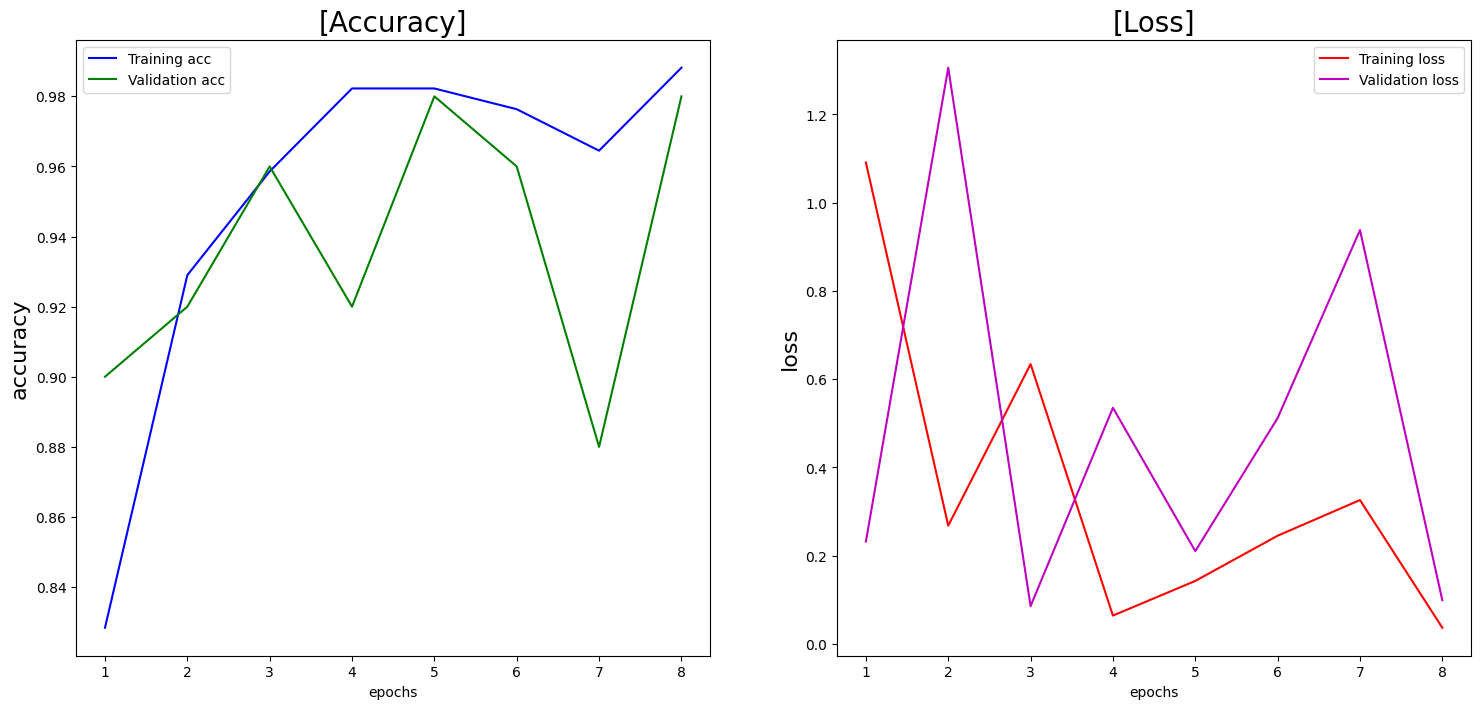

/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of Computer  (100).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of Computer  (97).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of Computer  (98).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of Computer  (99).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of computer .png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_product/Computer Mouse-a2Fyb (100).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_product/Computer Mouse-a2Fyb (97).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_im

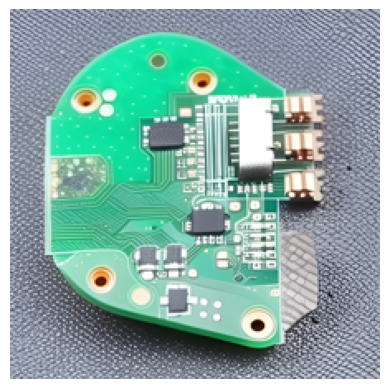

1/1 [==============================] - 0s 35ms/step
모델의 예측결과 label=mouse_parts
정확도:1.0
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_parts
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_parts


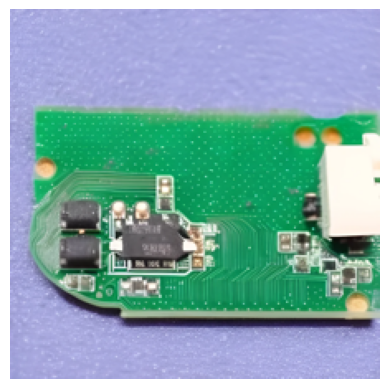

1/1 [==============================] - 0s 33ms/step
모델의 예측결과 label=mouse_parts
정확도:1.0
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 99.6
분류결과 : mouse_parts
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_parts


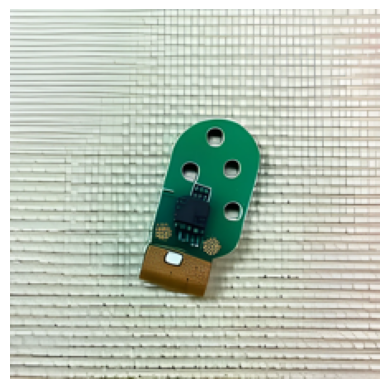

1/1 [==============================] - 0s 32ms/step
모델의 예측결과 label=mouse_parts
정확도:1.0
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 99.1
분류결과 : mouse_parts
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_parts


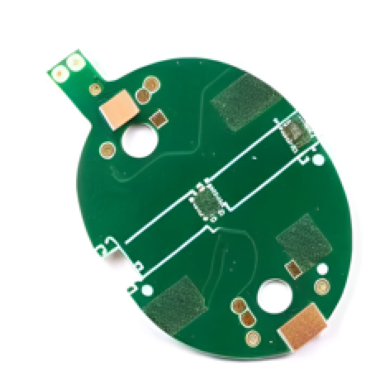

1/1 [==============================] - 0s 31ms/step
모델의 예측결과 label=mouse_product
정확도:1.0
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 89.5
분류결과 : mouse_parts
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_product


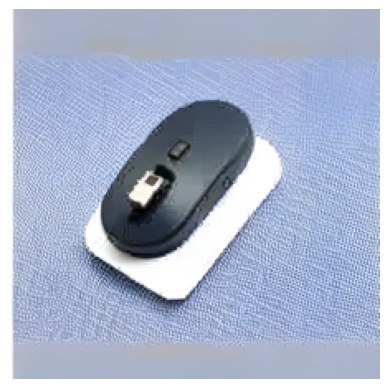

1/1 [==============================] - 0s 55ms/step
모델의 예측결과 label=mouse_product
정확도:1.0
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 98.9
분류결과 : mouse_product
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_product


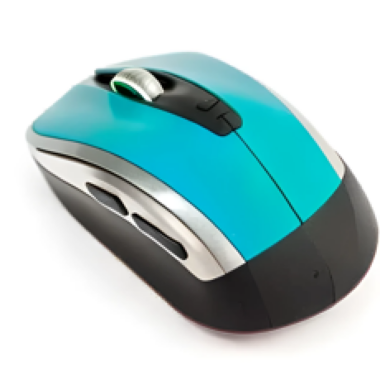

1/1 [==============================] - 0s 50ms/step
모델의 예측결과 label=mouse_product
정확도:1.0
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 95.4
분류결과 : mouse_product
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_product


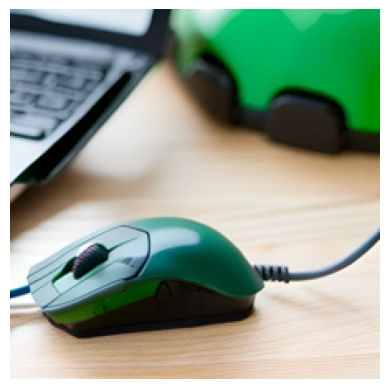

1/1 [==============================] - 0s 49ms/step
모델의 예측결과 label=mouse_product
정확도:1.0
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 98.0
분류결과 : mouse_product
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_product


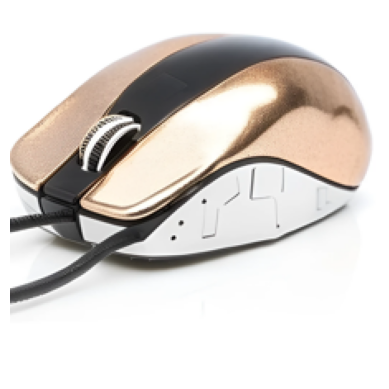

1/1 [==============================] - 0s 57ms/step
모델의 예측결과 label=mouse_product
정확도:1.0
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 96.4
분류결과 : mouse_product
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_product


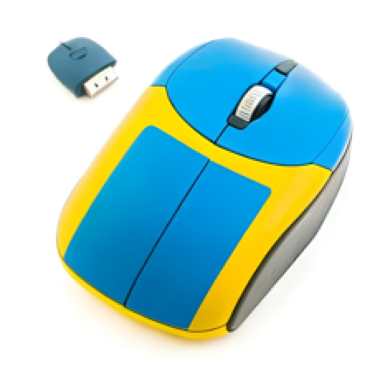

1/1 [==============================] - 0s 74ms/step
모델의 예측결과 label=mouse_product
정확도:1.0
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 99.5
분류결과 : mouse_product
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_product


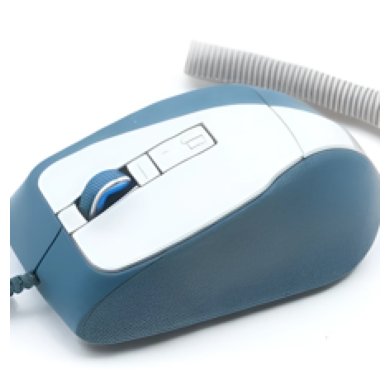

9/9 [==============================] - 7s 765ms/step - loss: 0.2308 - accuracy: 0.9822


[0.230818510055542, 0.9822485446929932]

In [ ]:
# Karlo_mouse image 사용했을때

# DataGenerator 객체 생성
datagen = DataGenerator()

# 학습용, 검증용 ImageDataGenerator 생성
train_datagen_with_augment      = datagen.make_datagen(True)
# train_datagen_without_augment   = datagen.make_datagen(False)
val_datagen_with_augment        = datagen.make_datagen(True)
# val_datagen_without_augment     = datagen.make_datagen(False)
test_datagen_with_augment        = datagen.make_datagen(True)
# test_datagen_without_augment     = datagen.make_datagen(False)

# 학습용, 검증용 입력 이미지 생성
train_generator_with_augment    = datagen.make_datagen_flow_from_dir(train_datagen_with_augment,'train')
# train_generator_without_augment = datagen.make_datagen_flow_from_dir(train_datagen_without_augment,'train')
val_generator_with_augment      = datagen.make_datagen_flow_from_dir(val_datagen_with_augment,'val')
# val_generator_without_augment   = datagen.make_datagen_flow_from_dir(val_datagen_without_augment,'val')
test_generator_with_augment      = datagen.make_datagen_flow_from_dir(test_datagen_with_augment,'test')
# test_generator_without_augment   = datagen.make_datagen_flow_from_dir(test_datagen_without_augment,'test')

# 학습모델 객체 생성
vgg16_with_augment      = Model('vgg16')
# vgg16_without_augment   = Model('vgg16')
resnet_with_augment     = Model('resnet')
# resnet_without_augment  = Model('resnet')

# pretrained model 다운로드 및 설정 : 위의 4가지 학습모델중 하나를 골라서 아래 진행
resnet_with_augment.make_pretrained_model()
# fine tuning을 위한 모델 구성
resnet_with_augment.make_finetuned_model()

# 학습 : 모델명이랑 hdf5 파일명이랑 동일하게 해주세요.
resnet_with_augment_history = resnet_with_augment.training('resnet_with_augment.hdf5',
                                                           train_generator_with_augment,
                                                           val_generator_with_augment)

# 학습결과 시각화
resnet_with_augment.plot(resnet_with_augment_history)

# 테스트 및 메타정보 입력
resnet_with_augment.classify_Karlo_img()

# 학습결과 점수화
resnet_with_augment.score(train_generator_with_augment)


## ■ VGG16 Model로 학습 및 테스트

Found 169 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 13s 1s/step - loss: 0.7747 - accuracy: 0.6568 - val_loss: 0.3906 - val_accuracy: 0.8400
Epoch 2/1000
9/9 [==============================] - ETA: 0s - loss: 0.4169 - accuracy: 0.7811
Epoch 2: val_loss improved from 0.39059 to 0.30361, saving model to /content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/model/vgg16_with_augment.hdf5
9/9 [==============================] - 12s 1s/step - loss: 0.4169 - accuracy: 0.7811 - val_loss: 0.3036 - val_accuracy: 0.9000
Epoch 3/1000
9/9 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.8757
Epoch 3: val_loss improved from 0.30361 to 0.22013, saving model to /content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/model/vgg16_with_augment.hdf5
9/9 [==============================] - 12s 1s/step - loss: 0.2943 - accuracy: 0.8757 - val_loss: 0.2201 - val_accuracy: 0.9200
Epoch 4/1000
9/9 [==============================] - ETA: 0s - loss:

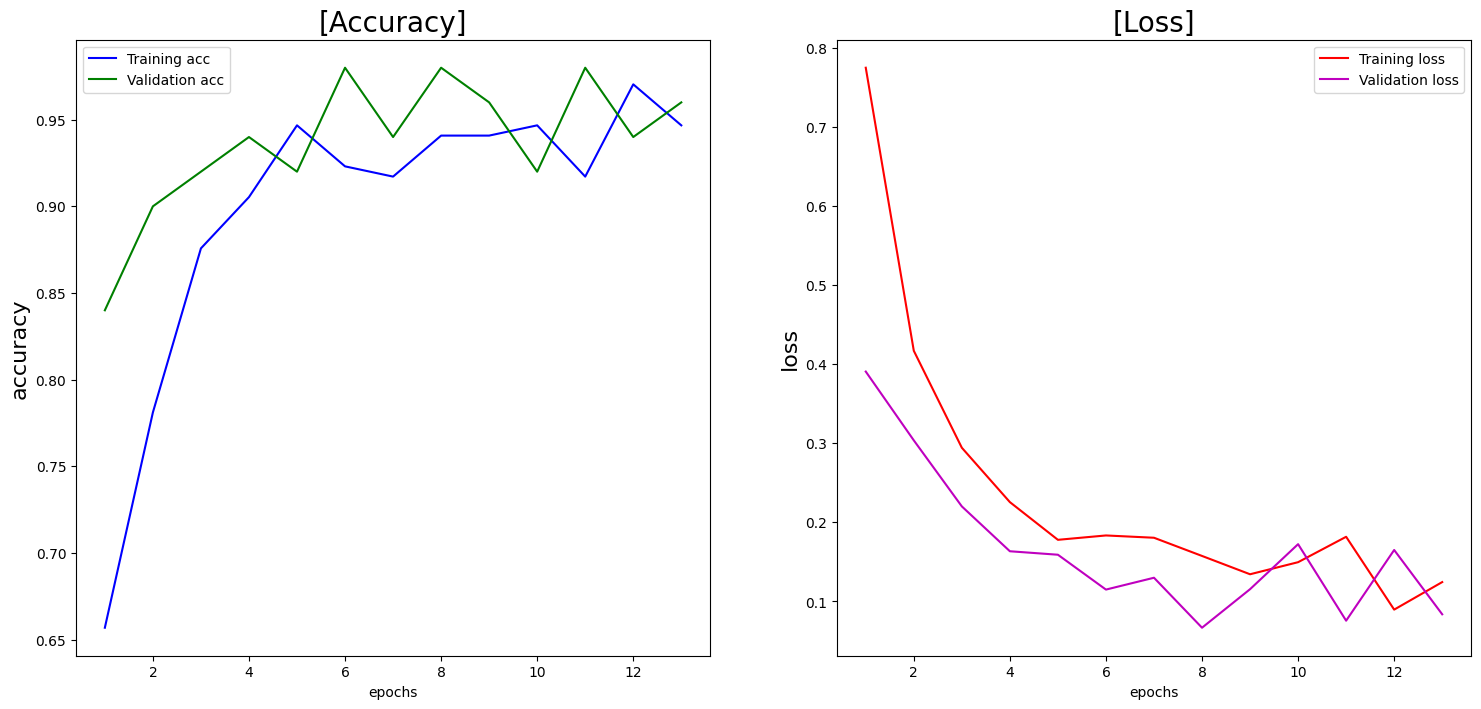

/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of Computer  (100).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of Computer  (97).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of Computer  (98).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of Computer  (99).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_parts/1 piece of computer .png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_product/Computer Mouse-a2Fyb (100).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_img/test/mouse_product/Computer Mouse-a2Fyb (97).png
/content/drive/MyDrive/KDT_Human/05_딥러닝/02_컴퓨터비전/02_Data파일/Karlo_im

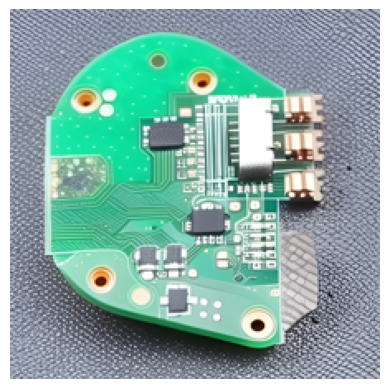

1/1 [==============================] - 0s 19ms/step
모델의 예측결과 label=mouse_parts
정확도:0.9997648596763611
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 72.0
분류결과 : Bogdan Hrastnik
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 100.0
분류결과 : mouse_parts


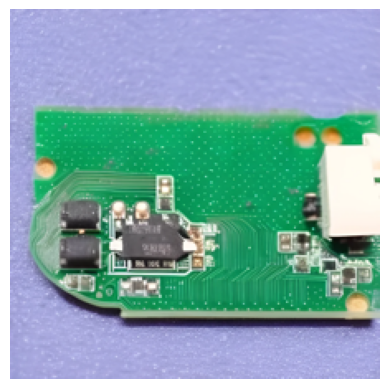

1/1 [==============================] - 0s 18ms/step
모델의 예측결과 label=mouse_parts
정확도:0.9959856867790222
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 72.0
분류결과 : Bogdan Hrastnik
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 99.6
분류결과 : mouse_parts


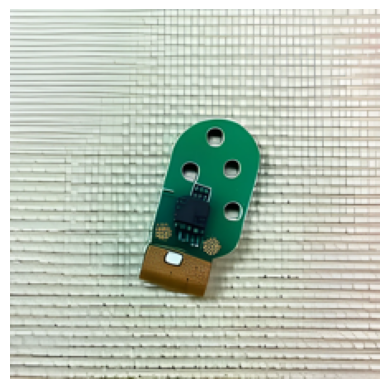

1/1 [==============================] - 0s 19ms/step
모델의 예측결과 label=mouse_parts
정확도:0.9909040331840515
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 72.0
분류결과 : Bogdan Hrastnik
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 99.1
분류결과 : mouse_parts


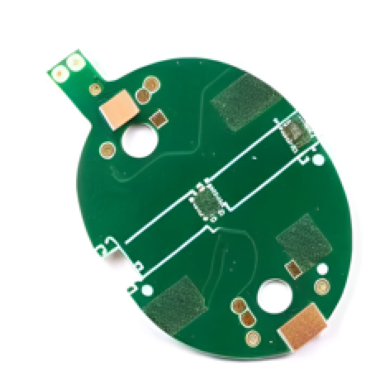

1/1 [==============================] - 0s 18ms/step
모델의 예측결과 label=mouse_parts
정확도:0.8945022225379944
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 72.0
분류결과 : Bogdan Hrastnik
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 89.5
분류결과 : mouse_parts


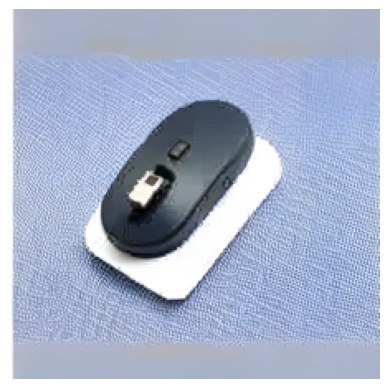

1/1 [==============================] - 0s 18ms/step
모델의 예측결과 label=mouse_product
정확도:0.9890772104263306
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 72.0
분류결과 : Bogdan Hrastnik
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 98.9
분류결과 : mouse_product


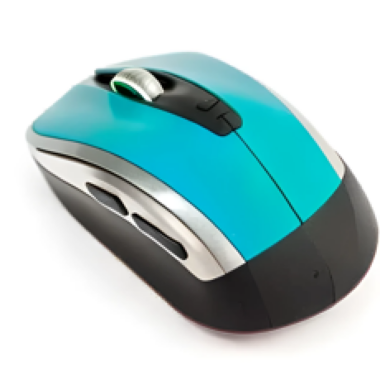

1/1 [==============================] - 0s 19ms/step
모델의 예측결과 label=mouse_product
정확도:0.9542437791824341
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 72.0
분류결과 : Bogdan Hrastnik
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 95.4
분류결과 : mouse_product


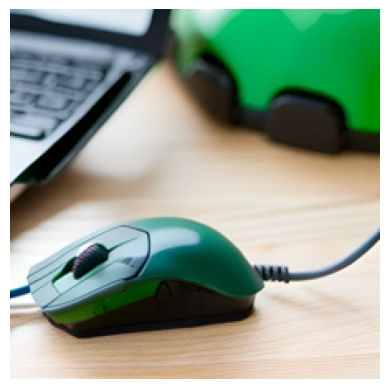

1/1 [==============================] - 0s 37ms/step
모델의 예측결과 label=mouse_product
정확도:0.9803722500801086
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 72.0
분류결과 : Bogdan Hrastnik
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 98.0
분류결과 : mouse_product


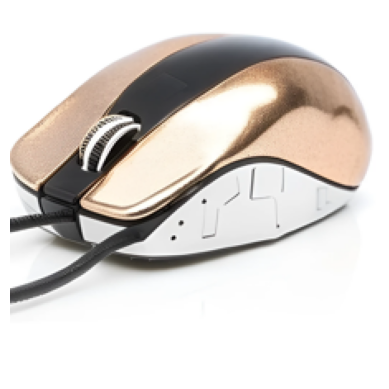

1/1 [==============================] - 0s 26ms/step
모델의 예측결과 label=mouse_product
정확도:0.9636029601097107
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 72.0
분류결과 : Bogdan Hrastnik
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 96.4
분류결과 : mouse_product


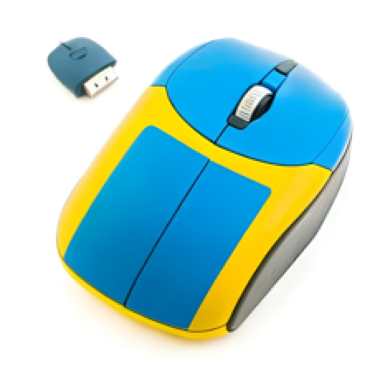

1/1 [==============================] - 0s 29ms/step
모델의 예측결과 label=mouse_product
정확도:0.9945206642150879
=== 이미지의 기존 메타정보 출력 ===
분류확률 : 72.0
분류결과 : Bogdan Hrastnik
모델의 예측결과를 이미지의 메타정보에 성공적으로 수정했습니다.
=== 이미지의 수정된 메타정보 출력 ===
분류확률 : 99.5
분류결과 : mouse_product


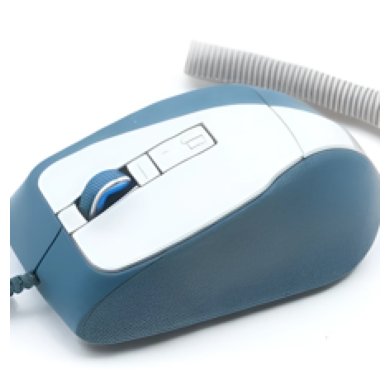

9/9 [==============================] - 7s 746ms/step - loss: 0.0779 - accuracy: 0.9822


[0.07787597179412842, 0.9822485446929932]

In [ ]:
# Karlo_mouse image 사용했을때

# DataGenerator 객체 생성
datagen_vgg = DataGenerator()

# 학습용, 검증용 ImageDataGenerator 생성
train_datagen_with_augment      = datagen_vgg.make_datagen(True)
# train_datagen_without_augment   = datagen_vgg.make_datagen(False)
val_datagen_with_augment        = datagen_vgg.make_datagen(True)
# val_datagen_without_augment     = datagen_vgg.make_datagen(False)
test_datagen_with_augment        = datagen_vgg.make_datagen(True)
# test_datagen_without_augment     = datagen_vgg.make_datagen(False)

# 학습용, 검증용 입력 이미지 생성
train_generator_with_augment    = datagen_vgg.make_datagen_flow_from_dir(train_datagen_with_augment,'train')
# train_generator_without_augment = datagen_vgg.make_datagen_flow_from_dir(train_datagen_without_augment,'train')
val_generator_with_augment      = datagen_vgg.make_datagen_flow_from_dir(val_datagen_with_augment,'val')
# val_generator_without_augment   = datagen_vgg.make_datagen_flow_from_dir(val_datagen_without_augment,'val')
test_generator_with_augment      = datagen_vgg.make_datagen_flow_from_dir(test_datagen_with_augment,'test')
# test_generator_without_augment   = datagen_vgg.make_datagen_flow_from_dir(test_datagen_without_augment,'test')

# 학습모델 객체 생성
vgg16_with_augment      = Model('vgg16')
# vgg16_without_augment   = Model('vgg16')
# resnet_with_augment     = Model('resnet')
# resnet_without_augment  = Model('resnet')

# pretrained model 다운로드 및 설정 : 위의 4가지 학습모델중 하나를 골라서 아래 진행
vgg16_with_augment.make_pretrained_model()
# fine tuning을 위한 모델 구성
vgg16_with_augment.make_finetuned_model()

# 학습 : 모델명이랑 hdf5 파일명이랑 동일하게 해주세요.
vgg16_with_augmentt_history = vgg16_with_augment.training('vgg16_with_augment.hdf5',
                                                          train_generator_with_augment,
                                                          val_generator_with_augment)

# 학습결과 시각화
vgg16_with_augment.plot(vgg16_with_augmentt_history)

# 테스트 및 메타정보 입력
vgg16_with_augment.classify_Karlo_img()

# 학습결과 점수화
vgg16_with_augment.score(train_generator_with_augment)